# 재구매 고객의 2차 구매 상품

## 라이브러리

In [1]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib # 주피터 노트북 시각화 한글 깨짐 방지
import networkx as nx

## 데이터 로드

In [2]:
path = "Preprocessing Data/Order Data/all_order_0617.xlsx" # 파일 경로
df_original = pd.read_excel(path) # 데이터 로드
df = df_original.copy() # raw 유지를 위한 복사
df

,주문일시,주문자ID,주문자ID_생성,가입구분,주문 시 회원등급,총 주문금액,총 결제금액,주문상품명,주문번호,수량,...,사용한 쿠폰명,주문서 쿠폰 할인금액,주문자명,주문자 가입일,주소,상세주소,주문자우편번호,총 실제 환불금액,결제수단,Frequency
0,2023-01-01 08:23:00,50232@정,정@2층좌측@50232,비회원,비회원,35000.0,38000,호안닉스 리치스톤,20230101-0000221,1,...,NaN,0,정**,NaT,경상남도합천군합천읍옥산로432층좌측,2층좌측,50232.0,0,신용카드,1.0
1,2023-01-01 08:38:00,12773@신,신@101동302@12773,비회원,비회원,35000.0,34114,호안닉스 리치스톤,20230101-0000242,1,...,NaN,0,신**,NaT,"경기도광주시오포읍창뜰아랫길45601(오포읍,프린스타운)101동302",101동302,12773.0,0,신용카드,1.0
2,2023-01-01 09:02:00,27482@고,고@102-303@27482,비회원,비회원,35000.0,72650,호안닉스 리치스톤,20230101-0000269,1,...,NaN,0,고**,NaT,"충청북도충주시형설로32(호암동,세영더-조은아파트)102-303",102-303,27482.0,0,신용카드,1.0
3,2023-01-01 09:02:00,27482@고,고@102-303@27482,비회원,비회원,35000.0,72650,로즈크리스탈 코이스톤,20230101-0000269,1,...,NaN,0,고**,NaT,"충청북도충주시형설로32(호암동,세영더-조은아파트)102-303",102-303,27482.0,0,신용카드,1.0
4,2023-01-01 09:41:00,12662@김,김@태평리@12662,비회원,비회원,35000.0,0,호안닉스 리치스톤,20230101-0000284,1,...,NaN,0,김**,NaT,경기도여주시가남읍대명산1길15(가남읍태평리,태평리,12662.0,0,선불금,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16109,2024-04-30 11:10:00,21558@이,이@803호@21558,비회원,비회원,46000.0,45200,아이아게이트 디오스톤,20240430-0000397,1,...,NaN,0,이**,NaT,"인천광역시남동구예술로192번길32(구월동,아트뷰타워)803호",803호,21558.0,0,신용카드,12.0
16110,2024-04-30 11:12:00,58611@강,강@포미타운402동1501호@58611,비회원,비회원,41000.0,41000,호안오닉스 카네스톤,20240430-0000405,1,...,NaN,0,강**,NaT,전라남도목포시용해지구로88번길24포미타운LH4단지아파트포미타운402동1501호,포미타운402동1501호,58611.0,0,무통장입금,1.0
16111,2024-04-30 12:02:00,3459828338@k,신@207-1304@3709,카카오가입,일반회원,96000.0,93000,레브 윈스톤 세트 4mm,20240430-0000455,1,...,회원가입 쿠폰,3000,신**,2024-04-30,서울특별시서대문구수색로100DMC래미안e편한세상207-1304,207-1304,3709.0,0,"쿠폰,신용카드",1.0
16112,2024-04-30 12:02:00,3459828338@k,신@207-1304@3709,카카오가입,일반회원,96000.0,93000,호안석 인페르노,20240430-0000455,1,...,회원가입 쿠폰,3000,신**,2024-04-30,서울특별시서대문구수색로100DMC래미안e편한세상207-1304,207-1304,3709.0,0,"쿠폰,신용카드",1.0


## 분석

In [3]:
# 날짜순으로 정렬
df = df.sort_values(by=['주문자ID_생성', '주문일시'])

# 첫 구매와 다음 구매를 짝짓기
pairs = defaultdict(int)

for customer_id, group in df.groupby('주문자ID_생성'):
    products = group['주문상품명'].tolist()
    for i in range(len(products) - 1):
        pairs[(products[i], products[i + 1])] += 1

# 결과를 데이터프레임으로 변환
result = pd.DataFrame(list(pairs.items()), columns=['pair', 'count'])
result[['first_purchase', 'next_purchase']] = pd.DataFrame(result['pair'].tolist(), index=result.index)
result.drop(columns=['pair'], inplace=True)

In [5]:
# 피벗 테이블 생성
pivot_table = result.pivot(index='first_purchase', columns='next_purchase', values='count').fillna(0)

In [17]:
# 결과 액셀로 내보내기
pivot_table.to_excel("result.xlsx")

## 시각화

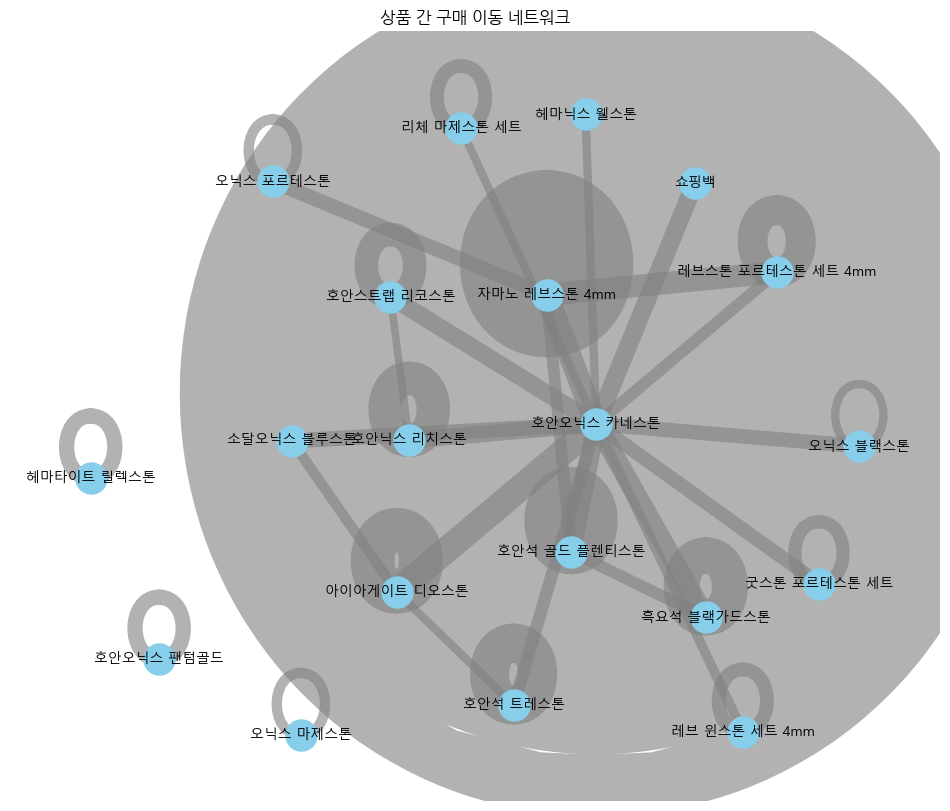

In [14]:
# 1. 데이터 준비
edges = result[result['count'] > 0]  # 횟수가 0이 아닌 항목만 (연결이 되는 항목만)

# 2. 그래프 생성
G = nx.from_pandas_edgelist(top_edges, source='first_purchase', target='next_purchase', edge_attr='count')

# 3. 시각화
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=1)  # k가 클수록 노드 간 간격이 넓어짐

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')

# 엣지(선) 그리기 (빈도수에 따라 선 굵기 조절)
weights = [G[u][v]['count'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w * 0.5 for w in weights], edge_color='gray', alpha=0.6)

# 라벨 그리기
nx.draw_networkx_labels(G, pos, font_family='Malgun Gothic', font_size=10)

plt.title("상품 간 구매 이동 네트워크")
plt.axis('off')
plt.show()